# Exploratory Analysis of parsed data

In [1]:
import os
import pandas as pd

df_articles = pd.read_pickle("../data/processed/parsed_articles.pkl")

<a id="table-of-contents"></a>

## Table of Contents

Overview of parsed data checks to guide data cleaning steps.

1. [High-Level Checks](#data_checks)  
   * Record counts (compared to expectations)
   * Check dates
   * Time distribution plot  

2. [Repeated Headlines](#headlines)  
   * Most frequent headlines  
   * Recurring topics  
   * Quasi-duplicate articles (same headline, similar body)  

3. [Sections Analysis](#sections)  

4. [Potential Issues](#issues)  
   * Working-class keywords review  
   * Data profiling summary


<a id="data_checks"></a>
## 1. High Level Checks 


[⬆ Return to Top](#table-of-contents)

### Record Counts

In [2]:
expected_n_articles = 500 * 86 + 305 + 361
parsed_articles = df_articles.shape[0]

In [3]:
try:
    assert expected_n_articles == parsed_articles, (
        f"Mismatch: expected {expected_n_articles}, got {parsed_articles}"
    )
    print(f"✅ Total number of articles parsed: {parsed_articles} — matches expectations.")
except AssertionError as e:
    print(f"❌ There's a mismatch. {e}")


✅ Total number of articles parsed: 43666 — matches expectations.


In [4]:
expected_n_source_files = 88
parsed_sources_files = len(set(df_articles["source_file"]))

In [5]:
try:
    assert expected_n_source_files == parsed_sources_files, (
        f"Mismatch: expected {expected_n_source_files}, got {parsed_sources_files}"
    )
    print(f"✅ Total number of source files parsed: {parsed_sources_files} — matches expectations.")
except AssertionError as e:
    print(f"❌ There's a mismatch. {e}")


✅ Total number of source files parsed: 88 — matches expectations.


### Check dates

In [6]:
# Check that no date values are missing
missing_dates_count = df_articles['date'].isna().sum()
try:
    assert missing_dates_count == 0, (
        f"Found {missing_dates_count} articles with missing dates:\n"
        f"{df_articles.loc[df_articles['date'].isna()]}"
    )
    print("✅ All articles have a date — expectations met.")
except AssertionError as e:
    print(f"❌ Date check failed. {e}")


✅ All articles have a date — expectations met.


In [7]:
# Validate that all 'date' entries can be parsed into valid dates
try:
    parsed_dates = pd.to_datetime(df_articles["date"], errors="coerce").dt.date
    invalid_dates = df_articles.loc[parsed_dates.isna()]
    invalid_count = invalid_dates.shape[0]

    assert invalid_count == 0, (
        f"Found {invalid_count} articles with invalid or missing dates:\n"
        f"{invalid_dates}"
    )

    print("✅ All articles have valid dates — expectations met.")
except AssertionError as e:
    print(f"❌ Date validation failed. {e}")


✅ All articles have valid dates — expectations met.


In [8]:
print("Number of articles with date at the end: ", 
int(df_articles.apply(lambda x: x['correction_appended'] or x['load_date_at_end'], axis = 1).sum()))

Number of articles with date at the end:  461


### Time Distribution Plot

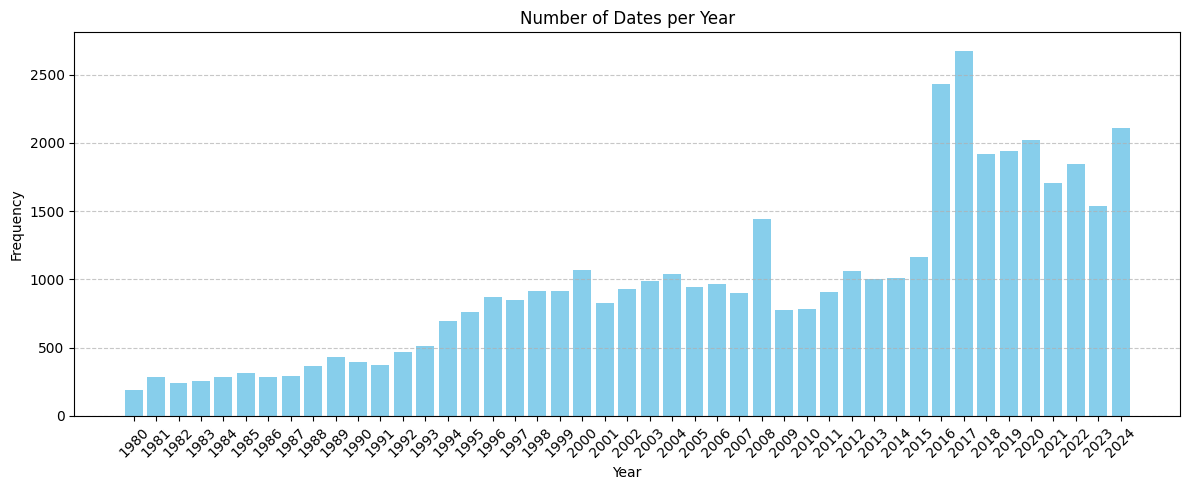

In [9]:
import matplotlib.pyplot as plt
from collections import Counter

# Group by year
years = [d.year for d in parsed_dates]
year_counts = Counter(years)

# Sort by year
sorted_years = sorted(year_counts)
frequencies = [year_counts[year] for year in sorted_years]

# Plot
plt.figure(figsize=(12, 5))
plt.bar(sorted_years, frequencies, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Number of Dates per Year')
plt.xticks(sorted_years, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<a id="headlines"></a>
## 2. Recurring Headlines


[⬆ Return to Top](#table-of-contents)

__To do:__ continue cleaning notebook.

__Question for Elena:__ does she approve the following organizational layout work to document decisions?

* Data processing folder: code + README.md file documentating decisions and reasoning.

* Data exploration folder: exploratory code that systematically analyzed data to arrive at decisions made above.

### Most frequent headlines

In [10]:
highest_frequency_titles = {key:value for key, value in dict(df_articles['title'].value_counts()).items() if value > 100}
highest_frequency_titles

{'No Headline In Original': np.int64(368), 'Movie guide': np.int64(101)}

In [11]:
df_no_headline = df_articles.loc[df_articles["title"] == "No Headline In Original"]
df_no_headline.head(2)

,title,publisher,date,section,length,body,correction_appended,load_date_at_end,source_file
446,No Headline In Original,The New York Times,2024-09-01,Section MB; Column 0; Metropolitan Desk; Pg. 3...,533 words,"\n\nIn the Schools: Dress Codes, Self-Expressi...",False,False,NYT/55.DOCX
457,No Headline In Original,The New York Times,2022-01-30,Section MB; Column 0; Metropolitan Desk; Pg. 3...,774 words,"\n\nHow Fire Defined the Bronx, and Us\nReader...",False,False,NYT/55.DOCX


In [12]:
select_index = 0 # select index to view the body of a different article
print(df_no_headline['body'].iloc[select_index])



In the Schools: Dress Codes, Self-Expression and Inequity
Readers responded by letter and at nytimes.com to Ginia Bellafante's Big City column on Aug. 18 about student dress codes and whether school uniforms should be required. Comments were edited.   I grew up in a working-class family, only ever had thrift store clothes, and was a social pariah because of that. Now my kid attends a New York City charter school where uniforms are required. I love it. The uniform completely removes any sense of ever having the ''wrong'' clothes, which I can attest from personal experience means that a major distraction is just completely removed from the day's equation. There's still some room for personal expression. There are dress, skirt, pants and shorts options, and two possible colors of shirts.
  Emily St. John Mandel, New York
  Every new school year, we grapple with how to make sure that our students are mindful, respectful and safe while maintaining independence and self-expression. This ye

In [13]:
# to view examples from other publishers
select_index = 0
select_publisher = "Chicago Daily Herald"
df_no_headline_select_publisher = df_no_headline.loc[df_no_headline["publisher"] == "Chicago Daily Herald"]
print(df_no_headline_select_publisher['body'].iloc[select_index])



This feeling isn't envy, it's anger
Columnist Ruben Navarette is way out of touch with the average person. His Feb. 26 column on income envy is what is wrong with the path America is heading down.
The sentiment he feels is not envy, but anger. The average working person just wants a fair shake on a level playing field, but the deck is stacked against them.
The wealthy and upper class buy legislation that only benefits them. How can you explain CEO pay of hundreds of millions while the working person is faced with drastic pay cuts, loss of benefits, competition from illegal aliens (undocumented to Navarette), layoffs and loss of pensions after years of service.
Today's worker is treated as a machine and can be disposed of at a moment's notice. It does not matter if you are a truck driver or a computer programmer, your job is not safe, no matter what your education level.
Robert Schneyr
South Elgin
Bush wants to repeat NAFTA mistake
The Hershey Company is laying off 1,500 workers - a t

__Observation:__ A manual review of a sample of articles titled "No Headline In Original" reveals that the original source data contains this exact title, confirming it is not a parsing error. In most cases, the article body consists of multiple readers’ notes to the editor, each with its own heading; however, there are exceptions to this pattern.

__Decision:__ During data cleaning, separate readers’ notes to the editor from the main dataset to enable independent analysis.

__Question for Elena:__ We had decided to do nothing about these articles, but incosistent with decision about keeping notes to editor seperate. Ok with this updated decision?

### Headlines with medium frequency

In [14]:
# Repeated titles
{key: value for key, value in dict(df_articles["title"].value_counts()).items() if value > 20 and value < 105}

{'Movie guide': np.int64(101),
 'Movie Guide': np.int64(36),
 'New & Noteworthy Paperbacks': np.int64(36),
 'Letters to the Editor': np.int64(34),
 'MOVIE GUIDE': np.int64(33),
 'Paperback Row': np.int64(30),
 'inside track': np.int64(28),
 'Art': np.int64(27),
 'Readers Write': np.int64(27),
 'Four stars: superior. Three stars: good. Two stars: average. One star: poor. D (': np.int64(25),
 'Marco Rubio; REPUBLICAN': np.int64(24)}

In [15]:
# select title
select_title = "MOVIE GUIDE"
select_index = 0
print(df_articles.loc[df_articles["title"] == select_title]["body"].iloc[select_index])



     A selective listing by critics of The Times of new or noteworthy movies and film series playing this weekend in New York City. * denotes a highly recommended film or series. Ratings and running times are in parentheses. An index of reviews of films opening today appears on Page 8.

Now Playing

* "AMELIE," starring Audrey Tautou and Mathieu Kassovitz. Directed by Jean-Pierre Jeunet (R, 120 minutes; in French, with English subtitles). Amelie (Ms. Tautou) is a waitress in Paris and tinkers with the lives of her friends. When she falls in love with Nino (Mr. Kassovitz), she can't be direct and let him know how she feels. Instead, she pulls him into an elaborate courtship dance that turns life in Paris into a game of Twister with a treasure hunt added to the mix. Nino trails after Amelie, still the mystery woman to him, as she leaves clues about herself everywhere. By the climax, the movie segues into a rumination on loss and the perils of being too playful. The film's original Fren

__Observation:__ We manually reviewed a selection of articles for each frequently repeated title and found that they fell into two main groups:

1. Not relevant for our analysis: These articles typically consist of recurring lists or recommendations related to movies, books, and the arts, accompanied by only brief descriptions. Given the limited depth of information, we determined they do not meet the requirements for our analysis.

    __Decision__: Filter out these articles.

    __Applies to__: Articles with titles "New & Noteworthy Paperbacks", "Paperback Row", "Art", "Four stars: superior. Three stars: good. Two stars: average. One star: poor. D (", "Movie guide", "MOVIE GUIDE".


2. Readers’ notes to the editor: These articles, including Letters to the Editor and Readers Write, document conversations between readers and the publication. While not all are directly related to the working class, the presence of at least one working-class keyword in a set of reader responses qualified the entire set for inclusion.

    __Decision:__ Keep these articles, but store them separately from the main dataset for independent study.

    __Applies to:__ Articles titled 'Letters to the Editor' and "Readers Write"

### Low-frequency headlines

In [16]:
# Repeated topics
repeated_articles = {key: value for key, value in dict(df_articles["title"].value_counts()).items() if value > 1 and value < 5}

first10pairs = {k: repeated_articles[k] for k in list(repeated_articles)[:10]}
first10pairs


{"LETTERS TO THE EDITOR;\nREADERS' LETTERS, FAXES, PHONE CALLS AND E-MAILS": np.int64(4),
 'CONNECTICUT GUIDE': np.int64(4),
 'Radical move: being a Democrat; Bernie SandersDEMOCRAT': np.int64(4),
 'Film in Review': np.int64(4),
 'REGION A BREEDING GROUND FOR NFL COACHES': np.int64(4),
 'INSIDE': np.int64(4),
 'HOT DISH POLITICS': np.int64(4),
 'Did caring for sick daughter cost mother Walmart job?; Woman sues, saying family leave act was disregarded.': np.int64(4),
 "What's on Tuesday": np.int64(4),
 'The Crack Up QUEEN; From Laugh-In to Grace and Frankie, Lily Tomlin never fails to make us smile.': np.int64(4)}

In [17]:
df_select_title = df_articles.loc[df_articles["title"] == "Anti-Trump crowd might need to swallow pride; FROM THE RIGHT"]
df_select_title

,title,publisher,date,section,length,body,correction_appended,load_date_at_end,source_file
21,Anti-Trump crowd might need to swallow pride; ...,Dayton Daily News (Ohio),2016-03-16,; Pg. A13,524 words,\n\nThe so-called Republican establishment is ...,False,False,Other publishers/Files (500) (10).DOCX
24,Anti-Trump crowd might need to swallow pride; ...,Dayton Daily News (Ohio),2016-03-16,BUSINESS; Pg. A13,525 words,\n\nThe so-called Republican establishment is ...,False,False,Other publishers/Files (500) (10).DOCX
30,Anti-Trump crowd might need to swallow pride; ...,Dayton Daily News (Ohio),2016-03-16,; Pg. A13,524 words,\n\nThe so-called Republican establishment is ...,False,False,Other publishers/Files (500) (10).DOCX


In [18]:
# Note: Not identical bodies
text1 = df_select_title['body'].iloc[0]
text2 = df_select_title['body'].iloc[1]
text1 == text2

False

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def compute_similarity(text1: str, text2: str) -> float:
    """
    Compute the similarity score between two texts using TF-IDF and cosine similarity.

    Args:
        text1 (str): The first article or document.
        text2 (str): The second article or document.

    Returns:
        float: Similarity score between 0 and 1.
    """
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform([text1, text2])
    similarity_matrix = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
    return similarity_matrix[0][0]


In [20]:
# But close to identical bodies
float(compute_similarity(text1, text2))

0.9907584037797779

In [21]:
# sizable issue
int(sum(repeated_articles.values()))

2491

__To do:__ @Laura

* How many articles with similarity score above 90% and 97%. same title.

* similarity score on titles.

### Analyzing similarity scores for non-identical titles

In [22]:
import re

def standardize_text(text):
    # Remove all non-alphanumeric characters except spaces, then lowercase
    return re.sub(r'[^a-zA-Z0-9 ]', '', text).lower()

In [23]:
from ftfy import fix_text

df_articles['body_cleaned'] = df_articles['body'].apply(fix_text)
df_articles['title_cleaned'] = df_articles['title'].apply(fix_text)

# standardize: remove punctuation, keep spaces, change to lower case
df_articles['title_stand'] = df_articles['title'].apply(standardize_text)
df_articles['body_stand'] = df_articles['body'].apply(standardize_text)

Examples:

In [24]:
text1 = "Who Can Win America’s Politics of Humiliation?"
text2 = "Who Can Win America's Politics of Humiliation?"
print(f"Exact match: {text1 == text2}")
print(f"Exact match after fixing text: {fix_text(text1) == fix_text(text2)}")
print(f"Exact match after standardixing text: {standardize_text(text1) == standardize_text(text2)}")

Exact match: False
Exact match after fixing text: True
Exact match after standardixing text: True


In [25]:
text1 = "Fiery 'Deepwater Horizon' strikes black gold; Harrowing tale of the oil rig explosion is carnage done right; MOVIE REVIEW"
text2 = 'Fiery ‘Deepwater Horizon’ strikes black gold; Harrowing tale of the oil rig explosion is carnage done right MOVIE REVIEW'
print(f"Exact match: {text1 == text2}")
print(f"Exact match after fixing text: {fix_text(text1) == fix_text(text2)}")
print(f"Exact match after standardixing text: {standardize_text(text1) == standardize_text(text2)}")

Exact match: False
Exact match after fixing text: False
Exact match after standardixing text: True


In [26]:
titles = list(set(df_articles['title']))
len(titles)

40936

In [27]:
titles = list(set(df_articles['title_cleaned']))
len(titles)

40751

In [28]:
titles = list(set(df_articles['title_stand']))
len(titles)

40498

In [29]:
import re

def compute_similarity(text1: str, text2: str) -> float:
    """
    Compute a simple word-overlap similarity score between two texts.
    Uses Jaccard similarity (intersection over union of unique words).
    
    Args:
        text1 (str): The first article or document.
        text2 (str): The second article or document.

    Returns:
        float: Similarity score between 0 and 1.
    """
    # Convert to lowercase, remove non-alphanumeric, split into words
    tokenize = lambda text: set(re.findall(r'\b\w+\b', text.lower()))
    
    words1 = tokenize(text1)
    words2 = tokenize(text2)
    
    if not words1 or not words2:
        return 0.0  # Avoid division by zero
    
    overlap = len(words1 & words2)
    union = len(words1 | words2)
    
    return overlap / union


In [ ]:
import pickle
similar_dict_path = "../data/processed/similar_dict_75.pkl"


if os.path.exists(similar_dict_path):
    # Loaddictionary from pickle file
    with open("similar_dict.pkl", "rb") as f:
        similar_dict = pickle.load(f)
else:   
    threshold = .75# .90 # original was .90
    print(f"Start similarity comparison with {threshold} threshold.")
    similar_dict = {}  # start empty
    titles = list(set(df_articles['title_stand']))
    n = len(titles)

    import time
    start_time = time.time()

    for i in range(n):
        for j in range(i + 1, len(titles)):  # skip repeats
            score = compute_similarity(titles[i], titles[j])
            if score > threshold:
                similar_dict.setdefault(titles[i], []).append((titles[j], score))
                similar_dict.setdefault(titles[j], []).append((titles[i], score))

    end_time = time.time()
    print(f"Elapsed time: {(end_time - start_time) / 60:.4f} minutes")
    
    # Save dictionary to a pickle file
    with open(similar_dict_path, "wb") as f:
        pickle.dump(similar_dict, f)


Start similarity comparison with 0.75 threshold.


In [ ]:
len(similar_dict)

In [ ]:
stand_text1 = list(similar_dict.keys())[0]
title1 = df_articles.loc[df_articles['title_stand'] == stand_text1]['title'].iloc[0]

stand_text2 = similar_dict[list(similar_dict.keys())[0]][0][0]
title2 = df_articles.loc[df_articles['title_stand'] == stand_text2]['title'].iloc[0]

print(f"Matching headlines example:\n\t{title1}\n\t{title2}")
print(f"\nStandardized versions:\n\t{stand_text1}\n\t{stand_text2}")

In [56]:
stand_text1 = list(similar_dict.keys())[0] # from 90% threshold
title1 = df_articles.loc[df_articles['title_stand'] == stand_text1]['title'].iloc[0]

stand_text2 = similar_dict[list(similar_dict.keys())[0]][0][0]
title2 = df_articles.loc[df_articles['title_stand'] == stand_text2]['title'].iloc[0]

print(f"Matching headlines example:\n\t{title1}\n\t{title2}")
print(f"\nStandardized versions:\n\t{stand_text1}\n\t{stand_text2}")

Matching headlines example:
	Can baseball save us from politics?
	Baseball: Can baseball save us from politics?

Standardized versions:
	can baseball save us from politics
	baseball can baseball save us from politics


__Suggestion:__ create a "title_tokens" field to use to find near-duplicates in next section. for deduplication use the standardized text. for other purposes, such as analysis of who working class, use cleaned text.

__Question for Elena:__ approve?

### Analyzing similarity scores for bodies with the same title

In [64]:
#!pip install ftfy
before_n = df_articles.shape[0]
df_articles.drop_duplicates(subset=["body_stand", "title_stand"], keep="first", inplace=True)
after_n = df_articles.shape[0]
print(f"Number of dropped duplicates: {before_n - after_n}.")

Number of dropped duplicates: 324.


__Question:__

* how to decide which column to keep when fields other than body and title are different? (need to apply a filter)

In [65]:
df_articles = df_articles.reset_index(drop=True)

In [36]:
# articles with same titles
repeated_articles = {key: value for key, value in dict(df_articles["title_stand"].value_counts()).items() if value > 1 and value < 20}
first10pairs = {k: repeated_articles[k] for k in list(repeated_articles)[:10]}
first10pairs

{'the listings art': np.int64(19),
 'books of the times': np.int64(17),
 'crime': np.int64(17),
 'at the movies': np.int64(17),
 'letters': np.int64(16),
 'bernie sanders radical move being a democrat democrat': np.int64(14),
 'movies new and noteworthy': np.int64(14),
 'letters from readers': np.int64(14),
 'marco rubio republican': np.int64(14),
 'news summary': np.int64(13)}

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import numpy as np


def compute_similarity(text1: str, text2: str) -> float:
    """
    Compute the similarity score between two texts using TF-IDF and cosine similarity.
    """
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform([text1, text2])
    similarity_matrix = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
    return similarity_matrix[0][0]


def mark_duplicates(group, threshold):
    """
    Mark duplicates within a group based on the given similarity threshold.
    Also records the index of the first matching duplicate.
    """
    seen_bodies = []
    seen_indices = []
    duplicate_flags = []
    duplicate_of_index = []

    for idx, row in group.iterrows():
        body = row['body_stand']
        is_duplicate = False
        duplicate_index = np.nan

        for seen_body, seen_idx in zip(seen_bodies, seen_indices):
            similarity = compute_similarity(body, seen_body)
            if similarity >= threshold:
                is_duplicate = True
                duplicate_index = seen_idx
                break

        duplicate_flags.append(is_duplicate)
        duplicate_of_index.append(duplicate_index)

        if not is_duplicate:
            seen_bodies.append(body)
            seen_indices.append(idx)

    flag_col = f"is_near_duplicate_{int(threshold*100)}"
    idx_col = f"duplicate_of_index_{int(threshold*100)}"
    group[flag_col] = duplicate_flags
    group[idx_col] = duplicate_of_index
    return group


def add_duplicate_flags(df, group_col, thresholds):
    """
    Adds duplicate flags and duplicate-of index columns for each threshold.
    """
    df_out = df.copy()
    for t in thresholds:
        print(f"Obtaining near-duplicates flag for {t} threshold")

        
        df_out = (
            df_out.groupby(group_col, sort=False, group_keys=False)
                  .apply(lambda g: mark_duplicates(g.assign(**{group_col: g.name}), t), include_groups=False)
        )
        
        # return the title to the beginning
        #cols = ['title'] + [col for col in df_out.columns if col != 'title']
        #df_out = df_out[cols]
    return df_out

In [66]:
import time

temp_file_path = "../data/processed/parsed_articles_with_nearDup_indicator.pkl"
if os.path.exists(temp_file_path):
    df_articles = pd.read_pickle(temp_file_path)
else:

    start_time = time.time()

    thresholds = [0.90, 0.95, 0.98]
    df_articles = add_duplicate_flags(df_articles, "title_stand", thresholds)

    end_time = time.time()
    print(f"Elapsed time: {(end_time - start_time) / 60:.4f} minutes")
    
    df_articles.to_pickle(temp_file_path)

Obtaining near-duplicates flag for 0.9 threshold
Obtaining near-duplicates flag for 0.95 threshold
Obtaining near-duplicates flag for 0.98 threshold
Elapsed time: 7.2584 minutes


In [68]:
print("Number of near-duplicates")
print(f"\tAt 90% threshold: {df_articles['is_near_duplicate_90'].sum()}")
print(f"\tAt 95% threshold: {df_articles['is_near_duplicate_95'].sum()}")
print(f"\tAt 98% threshold: {df_articles['is_near_duplicate_98'].sum()}")

Number of near-duplicates
	At 90% threshold: 1315
	At 95% threshold: 1003
	At 98% threshold: 594


In [92]:
cols =  [col for col in df_articles.columns if col != 'title_stand'] + ['title_stand']
df_articles = df_articles[cols]

In [93]:
df_articles.head()

,title,publisher,date,section,length,body,correction_appended,load_date_at_end,source_file,body_cleaned,title_cleaned,body_stand,is_near_duplicate_90,duplicate_of_index_90,is_near_duplicate_95,duplicate_of_index_95,is_near_duplicate_98,duplicate_of_index_98,title_stand
0,Fleece of the Century; On Boxing,The New York Times,2017-08-27,SPORTS,1958 words,\n\nLAS VEGAS — The world finally had the two ...,False,False,NYT/22.DOCX,\n\nLAS VEGAS — The world finally had the two ...,Fleece of the Century; On Boxing,las vegas the world finally had the two of th...,False,NaN,False,NaN,False,NaN,fleece of the century on boxing
1,Ruling Adds to the Risk Of a Monopoly on Power,The New York Times,2019-06-28,Section A; Column 0; National Desk; Pg. 14,1472 words,\n\nAt some point or another over the last dec...,False,False,NYT/22.DOCX,\n\nAt some point or another over the last dec...,Ruling Adds to the Risk Of a Monopoly on Power,at some point or another over the last decade ...,False,NaN,False,NaN,False,NaN,ruling adds to the risk of a monopoly on power
2,Gerrymandering and the Rising Risk of a Monopo...,The New York Times,2019-06-28,UPSHOT,1483 words,\n\nAt some point or another over the last dec...,False,False,NYT/22.DOCX,\n\nAt some point or another over the last dec...,Gerrymandering and the Rising Risk of a Monopo...,at some point or another over the last decade ...,False,NaN,False,NaN,False,NaN,gerrymandering and the rising risk of a monopo...
3,How Republicans Can Make a Deal on Health Care...,The New York Times,2017-10-27,OPINION,945 words,\n\nA consensus is emerging on Capitol Hill ab...,False,False,NYT/22.DOCX,\n\nA consensus is emerging on Capitol Hill ab...,How Republicans Can Make a Deal on Health Care...,a consensus is emerging on capitol hill about ...,False,NaN,False,NaN,False,NaN,how republicans can make a deal on health care...
4,Harvard Suit Shows Edge Given to Elite In Recr...,The New York Times,2018-11-03,Section A; Column 0; National Desk; Pg. 16,1245 words,"\n\nBOSTON -- For the past three weeks, a succ...",False,False,NYT/22.DOCX,"\n\nBOSTON--For the past three weeks, a succes...",Harvard Suit Shows Edge Given to Elite In Recr...,boston for the past three weeks a succession ...,False,NaN,False,NaN,False,NaN,harvard suit shows edge given to elite in recr...


In [77]:
title = 'Marco Rubio; REPUBLICAN'

df_title = df_articles.loc[df_articles["title"] == title]
print(df_title.shape[0])
df_title

13


,title,publisher,date,section,length,body,correction_appended,load_date_at_end,source_file,body_cleaned,title_cleaned,body_stand,is_near_duplicate_90,duplicate_of_index_90,is_near_duplicate_95,duplicate_of_index_95,title_stand,is_near_duplicate_98,duplicate_of_index_98
2578,Marco Rubio; REPUBLICAN,Dayton Daily News (Ohio),2016-03-06,; Pg. SF6,1125 words,"\n\nAbout him\nMarco Rubio was born May 28, 19...",False,False,Other publishers/Files (500) (17).DOCX,"\n\nAbout him\nMarco Rubio was born May 28, 19...",Marco Rubio; REPUBLICAN,about himmarco rubio was born may 28 1971 in m...,False,NaN,False,NaN,marco rubio republican,False,NaN
2581,Marco Rubio; REPUBLICAN,Dayton Daily News (Ohio),2016-03-06,ELECTION EXTRA; Pg. SF6,1129 words,"\n\nAbout him\nMarco Rubio was born May 28, 19...",False,False,Other publishers/Files (500) (17).DOCX,"\n\nAbout him\nMarco Rubio was born May 28, 19...",Marco Rubio; REPUBLICAN,about himmarco rubio was born may 28 1971 in m...,True,2578.0,True,2578.0,marco rubio republican,False,NaN
2603,Marco Rubio; REPUBLICAN,Dayton Daily News (Ohio),2016-02-21,; Pg. SF7,1125 words,"\n\nAbout him\nMarco Rubio was born May 28, 19...",False,False,Other publishers/Files (500) (17).DOCX,"\n\nAbout him\nMarco Rubio was born May 28, 19...",Marco Rubio; REPUBLICAN,about himmarco rubio was born may 28 1971 in m...,True,2578.0,True,2578.0,marco rubio republican,True,2578.0
2634,Marco Rubio; REPUBLICAN,Dayton Daily News (Ohio),2016-02-14,; Pg. SF8,1125 words,"\n\nAbout him\nMarco Rubio was born May 28, 19...",False,False,Other publishers/Files (500) (17).DOCX,"\n\nAbout him\nMarco Rubio was born May 28, 19...",Marco Rubio; REPUBLICAN,about himmarco rubio was born may 28 1971 in m...,True,2578.0,True,2578.0,marco rubio republican,True,2578.0
2649,Marco Rubio; REPUBLICAN,Dayton Daily News (Ohio),2016-01-31,; Pg. SF14,1124 words,"\n\nAbout him\nMarco Rubio was born May 28, 19...",False,False,Other publishers/Files (500) (17).DOCX,"\n\nAbout him\nMarco Rubio was born May 28, 19...",Marco Rubio; REPUBLICAN,about himmarco rubio was born may 28 1971 in m...,True,2578.0,True,2578.0,marco rubio republican,True,2578.0
2669,Marco Rubio; REPUBLICAN,Dayton Daily News (Ohio),2016-01-24,; Pg. SF13,1124 words,"\n\nAbout him\nMarco Rubio was born May 28, 19...",False,False,Other publishers/Files (500) (17).DOCX,"\n\nAbout him\nMarco Rubio was born May 28, 19...",Marco Rubio; REPUBLICAN,about himmarco rubio was born may 28 1971 in m...,True,2578.0,True,2578.0,marco rubio republican,True,2578.0
2681,Marco Rubio; REPUBLICAN,Dayton Daily News (Ohio),2016-01-17,; Pg. SF13,1124 words,"\n\nAbout him\nMarco Rubio was born May 28, 19...",False,False,Other publishers/Files (500) (17).DOCX,"\n\nAbout him\nMarco Rubio was born May 28, 19...",Marco Rubio; REPUBLICAN,about himmarco rubio was born may 28 1971 in m...,True,2578.0,True,2578.0,marco rubio republican,True,2578.0
2696,Marco Rubio; REPUBLICAN,Dayton Daily News (Ohio),2016-01-10,; Pg. SF13,1124 words,"\n\nAbout him\nMarco Rubio was born May 28, 19...",False,False,Other publishers/Files (500) (17).DOCX,"\n\nAbout him\nMarco Rubio was born May 28, 19...",Marco Rubio; REPUBLICAN,about himmarco rubio was born may 28 1971 in m...,True,2578.0,True,2578.0,marco rubio republican,True,2578.0
2717,Marco Rubio; REPUBLICAN,Dayton Daily News (Ohio),2016-01-03,; Pg. SF13,1124 words,"\n\nAbout him\nMarco Rubio was born May 28, 19...",False,False,Other publishers/Files (500) (17).DOCX,"\n\nAbout him\nMarco Rubio was born May 28, 19...",Marco Rubio; REPUBLICAN,about himmarco rubio was born may 28 1971 in m...,True,2578.0,True,2578.0,marco rubio republican,True,2578.0
2727,Marco Rubio; REPUBLICAN,Dayton Daily News (Ohio),2015-12-27,; Pg. SF14,1124 words,"\n\nAbout him\nMarco Rubio was born May 28, 19...",False,False,Other publishers/Files (500) (17).DOCX,"\n\nAbout him\nMarco Rubio was born May 28, 19...",Marco Rubio; REPUBLICAN,about himmarco rubio was born may 28 1971 in m...,True,2578.0,True,2578.0,marco rubio r

In [80]:
idx_for_comparison = [2578, 2581]
df_articles.iloc[idx_for_comparison]

,title,publisher,date,section,length,body,correction_appended,load_date_at_end,source_file,body_cleaned,title_cleaned,body_stand,is_near_duplicate_90,duplicate_of_index_90,is_near_duplicate_95,duplicate_of_index_95,title_stand,is_near_duplicate_98,duplicate_of_index_98
2578,Marco Rubio; REPUBLICAN,Dayton Daily News (Ohio),2016-03-06,; Pg. SF6,1125 words,"\n\nAbout him\nMarco Rubio was born May 28, 19...",False,False,Other publishers/Files (500) (17).DOCX,"\n\nAbout him\nMarco Rubio was born May 28, 19...",Marco Rubio; REPUBLICAN,about himmarco rubio was born may 28 1971 in m...,False,NaN,False,NaN,marco rubio republican,False,NaN
2581,Marco Rubio; REPUBLICAN,Dayton Daily News (Ohio),2016-03-06,ELECTION EXTRA; Pg. SF6,1129 words,"\n\nAbout him\nMarco Rubio was born May 28, 19...",False,False,Other publishers/Files (500) (17).DOCX,"\n\nAbout him\nMarco Rubio was born May 28, 19...",Marco Rubio; REPUBLICAN,about himmarco rubio was born may 28 1971 in m...,True,2578.0,True,2578.0,marco rubio republican,False,NaN


In [81]:
text1 = df_articles.iloc[idx_for_comparison[0]]['body']
text2 = df_articles.iloc[idx_for_comparison[1]]['body']
print(compute_similarity(text1, text2))

0.9940840055701273


In [82]:
print(text1)



About him
Marco Rubio was born May 28, 1971, in Miami to parents who immigrated to the United States from Cuba in 1956. As he noted in the first GOP debate: "My father was a bartender. And the journey from the back of that bar to this stage tonight, to me, that is the essence of the American dream."
He earned his law degree from the University of Miami. In 2000, he won election to the Florida House of Representatives, and after he was re-elected a second time he became speaker of the Florida House. In 2010, he was elected to the U.S. Senate from Florida.
He and his wife have four children.
His stand
The U.S. senator entered the presidential race April 13 by offering the nation a younger generation of leadership that breaks free of ideas "stuck in the 20th century, " a jab at both Democratic favorite Hillary Rodham Clinton and his one-time Republican mentor, former Florida Gov. Jeb Bush.
At he public kickoff at Freedom Tower, the Miami landmark that was the first stop for tens of thou

In [83]:
print(text2)



About him
Marco Rubio was born May 28, 1971, in Miami to parents who immigrated to the United States from Cuba in 1956. As he noted in the first GOP debate: “My father was a bartender. And the journey from the back of that bar to this stage tonight, to me, that is the essence of the American dream.” 
He earned his law degree from the University of Miami. In 2000, he won election to the Florida House of Representatives, and after he was re-elected a second time he became speaker of the Florida House. In 2010, he was elected to the U.S. Senate from Florida. 
He and his wife have four children. 
His stand 
The U.S. senator entered the presidential race April 13 by offering the nation a younger generation of leadership that breaks free of ideas “stuck in the 20th century, “ a jab at both Democratic favorite Hillary Rodham Clinton and his one-time Republican mentor, former Florida Gov. Jeb Bush. 
At he public kickoff at Freedom Tower, the Miami landmark that was the first stop for tens of

In [84]:
df_dup_range1 = df_articles.loc[df_articles['is_near_duplicate_90'] & ~df_articles['is_near_duplicate_95']]
df_dup_range1.head()

,title,publisher,date,section,length,body,correction_appended,load_date_at_end,source_file,body_cleaned,title_cleaned,body_stand,is_near_duplicate_90,duplicate_of_index_90,is_near_duplicate_95,duplicate_of_index_95,title_stand,is_near_duplicate_98,duplicate_of_index_98
486,Fox in the Globalist Henhouse? Davos Awaits Tr...,The New York Times,2018-01-22,BUSINESS; dealbook,1005 words,"\n\nDAVOS, Switzerland — As the annual meeting...",False,False,NYT/22.DOCX,"\n\nDAVOS, Switzerland — As the annual meeting...",Fox in the Globalist Henhouse? Davos Awaits Tr...,davos switzerland as the annual meeting of th...,True,103.0,False,NaN,fox in the globalist henhouse davos awaits tru...,False,NaN
514,"If he’s to recover, Obama needs his friends ba...",Dayton Daily News (Ohio),2013-11-16,IDEAS & VOICES; Pg. A8,550 words,\n\nThe news about the health care law that is...,False,False,Other publishers/Files (500) (12).DOCX,\n\nThe news about the health care law that is...,"If he's to recover, Obama needs his friends ba...",the news about the health care law that is sup...,True,510.0,False,NaN,if hes to recover obama needs his friends back...,False,NaN
521,Sympathetic Trump supporter on SNL; ANOTHER VIEW,Dayton Daily News (Ohio),2016-10-27,BUSINESS; Pg. A13,755 words,"\n\nIn this polarizing election, it has been s...",False,False,Other publishers/Files (500) (12).DOCX,"\n\nIn this polarizing election, it has been s...",Sympathetic Trump supporter on SNL; ANOTHER VIEW,in this polarizing election it has been said t...,True,515.0,False,NaN,sympathetic trump supporter on snl another view,False,NaN
594,Political expert details why Ohio has key role...,Dayton Daily News (Ohio),2016-09-17,LOCAL & STATE; Pg. B4,751 words,\n\nOhio will punch well above its weight in t...,False,False,Other publishers/Files (500) (12).DOCX,\n\nOhio will punch well above its weight in t...,Political expert details why Ohio has key role...,ohio will punch well above its weight in the u...,True,593.0,False,NaN,political expert details why ohio has key role...,False,NaN
784,Soviet-era homes meet wrecking ball; A massive...,Dayton Daily News (Ohio),2017-04-23,; Pg. wapo11,931 words,\n\nTatyana Chaynikova wants to stay in her co...,False,False,Other publishers/Files (500) (12).DOCX,\n\nTatyana Chaynikova wants to stay in her co...,Soviet-era homes meet wrecking ball; A massive...,tatyana chaynikova wants to stay in her condem...,True,773.0,False,NaN,sovietera homes meet wrecking ball a massive u...,False,NaN


In [85]:
idx_for_comparison = [1114, 1188]
idx_for_comparison = [997, 1019]
df_articles.iloc[idx_for_comparison]

,title,publisher,date,section,length,body,correction_appended,load_date_at_end,source_file,body_cleaned,title_cleaned,body_stand,is_near_duplicate_90,duplicate_of_index_90,is_near_duplicate_95,duplicate_of_index_95,title_stand,is_near_duplicate_98,duplicate_of_index_98
997,Movie guide,Chicago Daily Herald,2023-04-28,TIMEOUT; Pg. 12,1178 words,\n\nMovie guide Four stars: superior. Three: g...,False,False,Other publishers/Files (500) (3).DOCX,\n\nMovie guide Four stars: superior. Three: g...,Movie guide,movie guide four stars superior three good two...,False,NaN,False,NaN,movie guide,False,NaN
1019,Movie guide,Chicago Daily Herald,2023-05-11,NEIGHBOR; Pg. 2,1327 words,\n\nFour stars: superior. Three: good. Two: av...,False,False,Other publishers/Files (500) (3).DOCX,\n\nFour stars: superior. Three: good. Two: av...,Movie guide,four stars superior three good two average one...,True,997.0,False,NaN,movie guide,False,NaN


<a id="sections"></a>
## 3. Sections Analysis


[⬆ Return to Top](#table-of-contents)

In [86]:
set(df_articles["section"][45:55])

{'ARTS',
 'ARTS; design',
 'BUSINESS',
 'Section A; Column 0; National Desk; Pg. 13',
 'Section A; Column 0; National Desk; Pg. 16; POLITICAL MEMO',
 'Section BR; Column 0; Book Review Desk; Pg. 11',
 'Section M2; Column 0; T: Design Magazine; Pg. 140',
 'US; politics',
 'WORLD; europe',
 'WORLD; middleeast'}

__To do:__

* Analyze sections @Guo.

<a id="issues"></a>
## 4. Potential Issues


[⬆ Return to Top](#table-of-contents)

__Missing "working class" keywords__

In [87]:
def clean_body(text):
    if isinstance(text, str):
        return (text
                .replace("  ", " ")
                .replace(" -", "-")
                .replace("- ", "-")
                .replace("-\xad", "-")
                .replace("‑", "-")
                .replace("-/", "-")
                .replace("-\n", "-"))
    return text  # Leave non-strings (e.g., NaN) unchanged

df_articles['body_cleaned'] = df_articles['body'].apply(clean_body)

In [88]:
df_missing_working_class = df_articles[[('working-class' not in str(i).lower()) and ('working class' not in str(i).lower()) and ('(working) class' not in str(i).lower()) for i in df_articles['body_cleaned']]]
df_missing_working_class = df_missing_working_class[[('working-class' not in str(i).lower()) and ('working class' not in str(i).lower()) for i in df_missing_working_class['title']]]

df_missing_working_class.head()

,title,publisher,date,section,length,body,correction_appended,load_date_at_end,source_file,body_cleaned,title_cleaned,body_stand,is_near_duplicate_90,duplicate_of_index_90,is_near_duplicate_95,duplicate_of_index_95,title_stand,is_near_duplicate_98,duplicate_of_index_98
1907,"Desperate Years: To Be Young, British and Lack...",The New York Times,2013-12-19,MOVIES,616 words,\n\nFor today’s socially conscious British fil...,False,False,NYT/23.DOCX,\n\nFor today’s socially conscious British fil...,"Desperate Years: To Be Young, British and Lack...",for todays socially conscious british filmmake...,False,NaN,False,NaN,desperate years to be young british and lackin...,False,NaN
1950,The G.O.P. Can Avoid A Disaster,The New York Times,2018-04-05,Section A; Column 0; Editorial Desk; Pg. 27; O...,1204 words,\n\nWith Democrats winning in normally deep re...,False,False,NYT/23.DOCX,\n\nWith Democrats winning in normally deep re...,The G.O.P. Can Avoid A Disaster,with democrats winning in normally deep red pl...,False,NaN,False,NaN,the gop can avoid a disaster,False,NaN
2729,"Crash lawyers like Boeing move Cook County, Il...",USA TODAY,2001-05-16,NEWS;,452 words,\n\nWhen Boeing Co. announced plans last week ...,False,False,Other publishers/Files (500) (17).DOCX,\n\nWhen Boeing Co. announced plans last week ...,"Crash lawyers like Boeing move Cook County, Il...",when boeing co announced plans last week to re...,False,NaN,False,NaN,crash lawyers like boeing move cook county ill...,False,NaN
3358,THERE'S SURGING DEMAND FOR CAD TALENT,Pittsburgh Post-Gazette,2018-05-30,BUSINESS; Pg. TP-50,800 words,\n\nToys. Pencils. Mugs. Lug nuts. Cans for nu...,False,False,Other publishers/Files (500) (9).DOCX,\n\nToys. Pencils. Mugs. Lug nuts. Cans for nu...,THERE'S SURGING DEMAND FOR CAD TALENT,toys pencils mugs lug nuts cans for nuts pins ...,False,NaN,False,NaN,theres surging demand for cad talent,False,NaN
3894,Abortion Politics Didn't Doom the G.O.P.,The New York Times,2008-12-07,Section WK; Column 0; Editorial Desk; Pg. 10; ...,1207 words,\n\n AN iron law of recent American politics...,False,False,NYT/39.DOCX,\n\n AN iron law of recent American politics d...,Abortion Politics Didn't Doom the G.O.P.,an iron law of recent american politics dic...,False,NaN,False,NaN,abortion politics didnt doom the gop,False,NaN


In [89]:
# percetnage time missing
fraction_missing = (df_missing_working_class.shape[0]) / df_articles.shape[0]
if fraction_missing > 0:
    print("Data issue: {}% of articles don't include the working class keyworks.".format(round(fraction_missing*100,2)))
else:
    print("Issue resolved.")

Data issue: 0.61% of articles don't include the working class keyworks.


In [90]:
df_missing_working_class["title"].iloc[0]

'Desperate Years: To Be Young, British and Lacking; Movie Review'

__Observation:__ Manual review of a sample of articles revealed that the "working-class" keywords are present in data outside the article title and body => not a parsing or data extraction issue. Some of the articles still appear to be relevant, but many are not.

__Decision:__ Keep articles until further analysis.

__To do:__ Look into articles starting with "Best Sellers:" (but also generalize to articles starting with topic:specific_info) @Burui

__Other observations__

__Observation:__ End of article sometimes contain extranous information.

__Decision:__ Remove "load-date:" and other dates from end of article.

__To do:__ look at patterns.